# scRNAseq Trajectory Analysis
Trajectory Analysis using Singel Cell Gene Expression Data of Neutrophil population

In [1]:
# install packages
!pip install numpy==1.23 pandas==1.5.3 matplotlib==3.6.0 scanpy==1.9.1 igraph==0.9.8 scvelo==0.2.4 loompy==3.0.6 anndata==0.8.0

  Obtaining dependency information for numpy==1.23 from https://files.pythonhosted.org/packages/e6/aa/323e1cf4f25025c6f67dcf179db754142f92847c9d592599dc01b78de460/numpy-1.23.0-cp310-cp310-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for pandas==1.5.3 from https://files.pythonhosted.org/packages/b8/6c/005bd604994f7cbede4d7bf030614ef49a2213f76bc3d738ecf5b0dcc810/pandas-1.5.3-cp310-cp310-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for matplotlib==3.6.0 from https://files.pythonhosted.org/packages/52/d2/3a88e32103fabe95b0658db9177e4dbe3f83744a61a79fbc537b06ae730c/matplotlib-3.6.0-cp310-cp310-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for scanpy==1.9.1 from https://files.pythonhosted.org/packages/51/87/a55c7992cba9b189de70eae37e9f1e2abe6fdaf3f087d30356f28698948e/scanpy-1.9.1-py3-none-any.whl.metadata
  Obtaining dependency information for igraph==0.9.8 from https://files.pythonhosted.org/packages/9e/83/215324049bcf3530d515958

In [2]:
# create directory for input files, download from server and extract to linux environment
!mkdir input-files

# download from server client-url 
!curl -o input-files/filtered_feature_bc_matrix.tar.gz https://cf.10xgenomics.com/supp/cell-exp/neutrophils/filtered_feature_bc_matrix.tar.gz
!curl -o input-files/WB_Lysis_3p_Introns_8kCells.loom https://cf.10xgenomics.com/supp/cell-exp/neutrophils/WB_Lysis_3p_Introns_8kCells.loom
!curl -o input-files/3p-Neutrophils-clusters.csv https://cf.10xgenomics.com/supp/cell-exp/neutrophils/3p-Neutrophils-clusters.csv
!curl -o input-files/3p-Neutrophils-UMAP-Projection.csv https://cf.10xgenomics.com/supp/cell-exp/neutrophils/3p-Neutrophils-UMAP-Projection.csv

# deconstruct g zipped tar file
!tar -xvzf input-files/filtered_feature_bc_matrix.tar.gz -C input-files/

# list in linux environment
!ls -lah input-files

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16.2M  100 16.2M    0     0  27.5M      0 --:--:-- --:--:-- --:--:-- 27.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 67.5M  100 67.5M    0     0  38.6M      0  0:00:01  0:00:01 --:--:-- 38.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 96967  100 96967    0     0  75324      0  0:00:01  0:00:01 --:--:-- 75343
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  185k  100  185k    0     0   809k      0 --:--:-- --:--:-- --:--:--  809k
x filtered_feature_bc_matrix/
x filtered_feature_bc_

In [3]:
# import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import scanpy as sc
import igraph
import scvelo as scv
import loompy as lmp
import anndata

import warnings
warnings.filterwarnings('ignore')

# Notes
* scvelo tool only calculates velocity
* next, need anchors for visualization
* UMAP yields projections
* barcode assignments are associated with different clusters
* UMAP + clusters come from Loupe

Import files from Loupe

In [4]:
# read in the subset of clusters exported from Loupe Browser
Clusters_Loupe = pd.read_csv("./input-files/3p-Neutrophils-clusters.csv", delimiter=',',index_col=0)

# create list with only Neutrophil Barcodes
# will be used later to subset the count matrix
Neutrophils_BCs = Clusters_Loupe.index

In [5]:
# read UMAP exported from Loupe Browser
UMAP_Loupe = pd.read_csv("./input-files/3p-Neutrophils-UMAP-Projection.csv", delimiter=',',index_col=0)

# tansform to Numpy (for formatting)
UMAP_Loupe = UMAP_Loupe.to_numpy()

import the GEX matrix



In [6]:
# import the GEX gene expression matrix (neutrophils 3' prime)

# define Path to cellranger output
Path10x='./input-files/filtered_feature_bc_matrix/'

# read filtered feature bc matrix output from cellranger count
Neutro3p = sc.read_10x_mtx(Path10x,var_names='gene_symbols',cache=True)
Neutro3p

# matrix: forced number of cells x num of genes 
# 8000 cells x 36601 genes (full dataset)

AnnData object with n_obs × n_vars = 8000 × 36601
    var: 'gene_ids', 'feature_types'

In [7]:
# view the barcodes (n_obs) = 8000
# number set in -force-cells
Neutro3p.obs

Empty DataFrame
Columns: []
Index: [AAACCCAAGGCACTCC-1, AAACCCACAACTCCCT-1, AAACCCAGTACGAGCA-1, AAACCCAGTTGTGCAT-1, AAACCCATCTTCGGAA-1, AAACGAAAGAACTTCC-1, AAACGAACAATTGCGT-1, AAACGAACACCGGAAA-1, AAACGAACAGATTTCG-1, AAACGAAGTTGTGGCC-1, AAACGCTAGACAACTA-1, AAACGCTAGGTCACAG-1, AAACGCTAGTAACAGT-1, AAACGCTCACCATAAC-1, AAACGCTCACTGGATT-1, AAACGCTTCGAGTCCG-1, AAAGAACAGCAGCCCT-1, AAAGAACAGCGACTAG-1, AAAGAACAGGGAGGCA-1, AAAGAACAGTCGAGGT-1, AAAGAACCAACCGTGC-1, AAAGAACCACTGCACG-1, AAAGAACCAGTGCGCT-1, AAAGAACGTCCTGTCT-1, AAAGAACTCAGCATCG-1, AAAGAACTCAGCTCTC-1, AAAGAACTCCCGTGTT-1, AAAGAACTCCGCATAA-1, AAAGAACTCGACATCG-1, AAAGAACTCGGCATCG-1, AAAGGATAGGAGCTGT-1, AAAGGATCACCCAAGC-1, AAAGGATCACGCGCAT-1, AAAGGATCAGCTGTAT-1, AAAGGATCAGCTTCCT-1, AAAGGATCAGGAATAT-1, AAAGGATGTATCGTTG-1, AAAGGATTCGACCAAT-1, AAAGGATTCGCAGATT-1, AAAGGGCCAGATGCGA-1, AAAGGGCGTACGAGTG-1, AAAGGGCGTCGATTTG-1, AAAGGGCGTGAATGAT-1, AAAGGGCGTTCAAGTC-1, AAAGGGCTCATTCATC-1, AAAGGGCTCGACCCAG-1, AAAGGGCTCTACCACC-1, AAAGGTAAGACGGTTG-1, AAAGGTAAGATTCGCT-1, AAAGGTAAGTGATCGG-1, AAAGGTACAAAGCAAT-1, AAAGGTACAAGTGGCA-1, AAAGGTACACAGCCTG-1, AAAGGTACATACAGAA-1, AAAGGTACATACAGGG-1, AAAGGTAGTCGAGATG-1, AAAGGTATCATGTCAG-1, AAAGGTATCCAAGCAT-1, AAAGGTATCGCAAGAG-1, AAAGGTATCTAAGCGT-1, AAAGTCCAGCACCGTC-1, AAAGTCCAGTAGGCCA-1, AAAGTCCGTACGGATG-1, AAAGTCCGTATCTCTT-1, AAAGTCCGTTCTCTAT-1, AAAGTCCTCGACACTA-1, AAAGTCCTCTACTGCC-1, AAAGTCCTCTGAGAAA-1, AAAGTCCTCTTAGCCC-1, AAAGTGAAGCGTTAGG-1, AAAGTGACACAAACGG-1, AAAGTGACAGACCAGA-1, AAAGTGAGTATCCCAA-1, AAAGTGAGTATCGCAT-1, AAAGTGAGTTCTAAGC-1, AAAGTGATCAAATAGG-1, AAAGTGATCGCCGAGT-1, AAAGTGATCTACGCAA-1, AAAGTGATCTTCGCTG-1, AAATGGAAGTCCTACA-1, AAATGGAGTACCAATC-1, AAATGGAGTAGTCACT-1, AAATGGAGTATCAAGA-1, AAATGGATCACCGGTG-1, AAATGGATCATCACAG-1, AACAAAGAGAACAAGG-1, AACAAAGCAATGTCAC-1, AACAAAGCAGTAACGG-1, AACAAAGGTCACTCGG-1, AACAAAGGTCCTATAG-1, AACAAAGTCCTCGATC-1, AACAAAGTCTGCCTGT-1, AACAACCCAGAGGCTA-1, AACAACCGTGTCACAT-1, AACAACCTCACAACCA-1, AACAACCTCATCGACA-1, AACAACCTCATGGCCG-1, AACAACCTCCCGAGGT-1, AACAACCTCCTCTCTT-1, AACAACCTCGACCTAA-1, ...]

[8000 rows x 0 columns]

In [8]:
# call the gene_ids (n_vars) = 36,601
Neutro3p.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'AC133551.1', 'AC136612.1', 'AC136616.1', 'AC136616.3', 'AC136616.2',
       'AC141272.1', 'AC023491.2', 'AC007325.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=36601)

In [9]:
# covnert to df
Neutro3p_df = Neutro3p.to_df()
Neutro3p_df.head()

MIR1302-2HG  FAM138A  OR4F5  AL627309.1  AL627309.3  \
AAACCCAAGGCACTCC-1          0.0      0.0    0.0         0.0         0.0   
AAACCCACAACTCCCT-1          0.0      0.0    0.0         0.0         0.0   
AAACCCAGTACGAGCA-1          0.0      0.0    0.0         0.0         0.0   
AAACCCAGTTGTGCAT-1          0.0      0.0    0.0         0.0         0.0   
AAACCCATCTTCGGAA-1          0.0      0.0    0.0         0.0         0.0   

                    AL627309.2  AL627309.5  AL627309.4  AP006222.2  \
AAACCCAAGGCACTCC-1         0.0         0.0         0.0         0.0   
AAACCCACAACTCCCT-1         0.0         0.0         0.0         0.0   
AAACCCAGTACGAGCA-1         0.0         0.0         0.0         0.0   
AAACCCAGTTGTGCAT-1         0.0         0.0         0.0         0.0   
AAACCCATCTTCGGAA-1         0.0         0.0         0.0         0.0   

                    AL732372.1  ...  AC133551.1  AC136612.1  AC136616.1  \
AAACCCAAGGCACTCC-1         0.0  ...         0.0         0.0         0.0   
AAACCCACAACTCCCT-1         0.0  ...         0.0         0.0         0.0   
AAACCCAGTACGAGCA-1         0.0  ...         0.0         0.0         0.0   
AAACCCAGTTGTGCAT-1         0.0  ...         0.0         0.0         0.0   
AAACCCATCTTCGGAA-1         0.0  ...         0.0         0.0         0.0   

                    AC136616.3  AC136616.2  AC141272.1  AC023491.2  \
AAACCCAAGGCACTCC-1         0.0         0.0         0.0         0.0   
AAACCCACAACTCCCT-1         0.0         0.0         0.0         0.0   
AAACCCAGTACGAGCA-1         0.0         0.0         0.0         0.0   
AAACCCAGTTGTGCAT-1         0.0         0.0         0.0         0.0   
AAACCCATCTTCGGAA-1         0.0         0.0         0.0         0.0   

                    AC007325.1  AC007325.4  AC007325.2  
AAACCCAAGGCACTCC-1         0.0         0.0         0.0  
AAACCCACAACTCCCT-1         0.0         0.0         0.0  
AAACCCAGTACGAGCA-1         0.0         0.0         0.0  
AAACCCAGTTGTGCAT-1         0.0         0.0         0.0  
AAACCCATCTTCGGAA-1         0.0         0.0         0.0  

[5 rows x 36601 columns]

Subset matrix into only neutrophils

In [10]:
# define which barcodes are associated with which cluster

# filter only neutrophil barcodes from AnnData object
Neutro3p = Neutro3p[Neutrophils_BCs]

# add clusters assignments from Loupe to object as new observation
Neutro3p.obs['Loupe'] = Clusters_Loupe

# add the UMAP coordinates from Loupe to object .obsm attribute
Neutro3p.obsm["X_umap"] = UMAP_Loupe

possible warning, can ignore:
> Trying to set attribute `.obs` of view, copying

Read in velocyto output and merge

In [11]:
# read velocyto output
VelNeutro3p = scv.read('./input-files/WB_Lysis_3p_Introns_8kCells.loom', cache=True)

# merge velocyto and cellranger outputs
Neutro3p = scv.utils.merge(Neutro3p, VelNeutro3p)

Neutro3p

AnnData object with n_obs × n_vars = 3343 × 36601
    obs: 'Loupe', 'Clusters', '_X', '_Y', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'gene_ids', 'feature_types', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_umap'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

possible warning, can ignore:
> Variable names are not unique. To make them unique, call `.var_names_make_unique

# Process dataset and obtain latent time values for each cell

In [12]:
# Standard scvelo processing to run Dynamical Mode
scv.pp.filter_and_normalize(Neutro3p, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(Neutro3p, n_pcs=30, n_neighbors=30)

scv.tl.recover_dynamics(Neutro3p)
scv.tl.velocity(Neutro3p, mode='dynamical')
scv.tl.velocity_graph(Neutro3p)
scv.tl.recover_latent_time(Neutro3p)

Neutro3p

Filtered out 35468 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/10 cores)


  0%|          | 0/67 [00:00<?, ?gene/s]

    finished (0:00:17) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)


  0%|          | 0/3343 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 5 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


AnnData object with n_obs × n_vars = 3343 × 1133
    obs: 'Loupe', 'Clusters', '_X', '_Y', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'gene_ids', 'feature_types', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'pca', 'neighbors', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs', 'loss'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu', 'fit_t', 'fit_tau', 'fit_tau_', 'velocity', 'velocity_u'
    obsp: 'distances', 'connectivities'

# Visualize Velocity Results

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_scVelo-umap-cluster.png


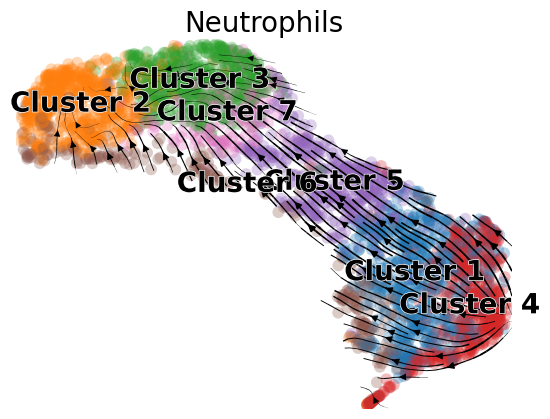

In [13]:
# visualize neutrophils in UMAP embedding and color by the cluster assignments 

# default plotting parameters
scv.pl.velocity_embedding_stream(Neutro3p,basis="umap",color="Loupe",title='Neutrophils',fontsize=20,legend_fontsize=20,min_mass=2,save='scVelo-umap-cluster.png')

saving figure to file ./figures/scvelo_scVelo-umap-latent_time.png


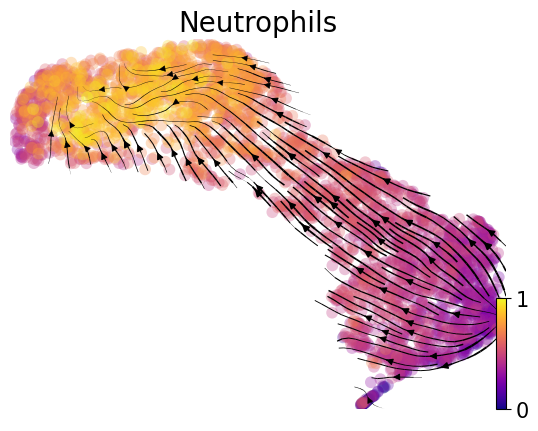

In [14]:
# visualize velocities in umap with latent time (differentiation)
# 0 immature to 1 mature
scv.pl.velocity_embedding_stream(Neutro3p,basis="umap",color="latent_time",title='Neutrophils',fontsize=20,legend_fontsize=20,min_mass=2,color_map="plasma",save='scVelo-umap-latent_time.png')

saving figure to file ./figures/scvelo_heatmap_scVelo-heatmap-latent_time.png


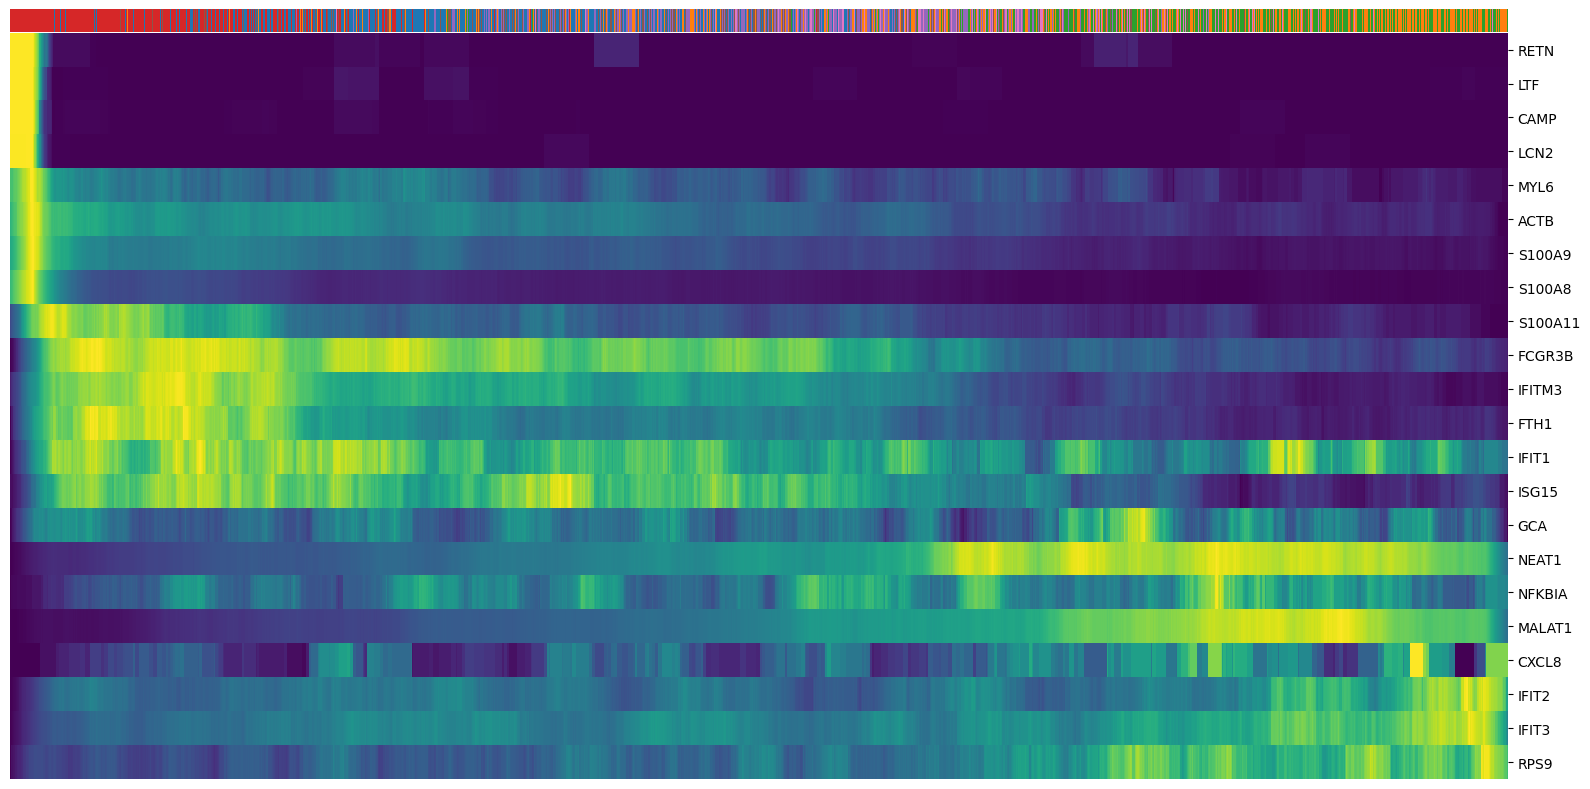

In [15]:
# produce heat map

# list genes that are differentially expressed during neutrophil maturation
# cells ordered by latent time, immautre neutrophil genes highlighted on left 

Genes=["RETN","LTF","CAMP","ACTB","GCA","LCN2",
         "S100A8","MYL6","S100A9","FCGR3B","S100A11","FTH1","IFIT1",
         "IFITM3","IFIT3","ISG15","IFIT2","RPS9","NEAT1","MALAT1","NFKBIA","CXCL8"]
scv.pl.heatmap(Neutro3p, var_names=Genes, sortby='latent_time', col_color='Loupe', n_convolve=100,figsize=(16,8),yticklabels=True,sort=True,colorbar=True,show=True,layer="count", save='scVelo-heatmap-latent_time.png')

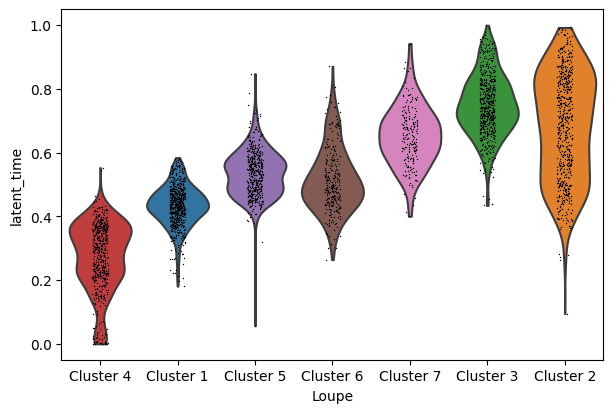

In [16]:
# visualize latent time for each cluster using violin plots
sc.pl.violin(Neutro3p, keys='latent_time',groupby="Loupe",order=["Cluster 4","Cluster 1","Cluster 5","Cluster 6","Cluster 7","Cluster 3","Cluster 2"], save='scVelo-violin-latent_time.png')

customize colors for the cluster and plot sizes

In [17]:
# Customize parameters for plots (Size, Color, etc)
scv.set_figure_params(style="scvelo")
pl.rcParams["figure.figsize"] = (10,10)
Colorss=["#E41A1C","#377EB8","#4DAF4A","#984EA3","#FF7F00","#FFFF33","#A65628","#F781BF"]

saving figure to file ./figures/scvelo_scVelo-umap-cluster.png


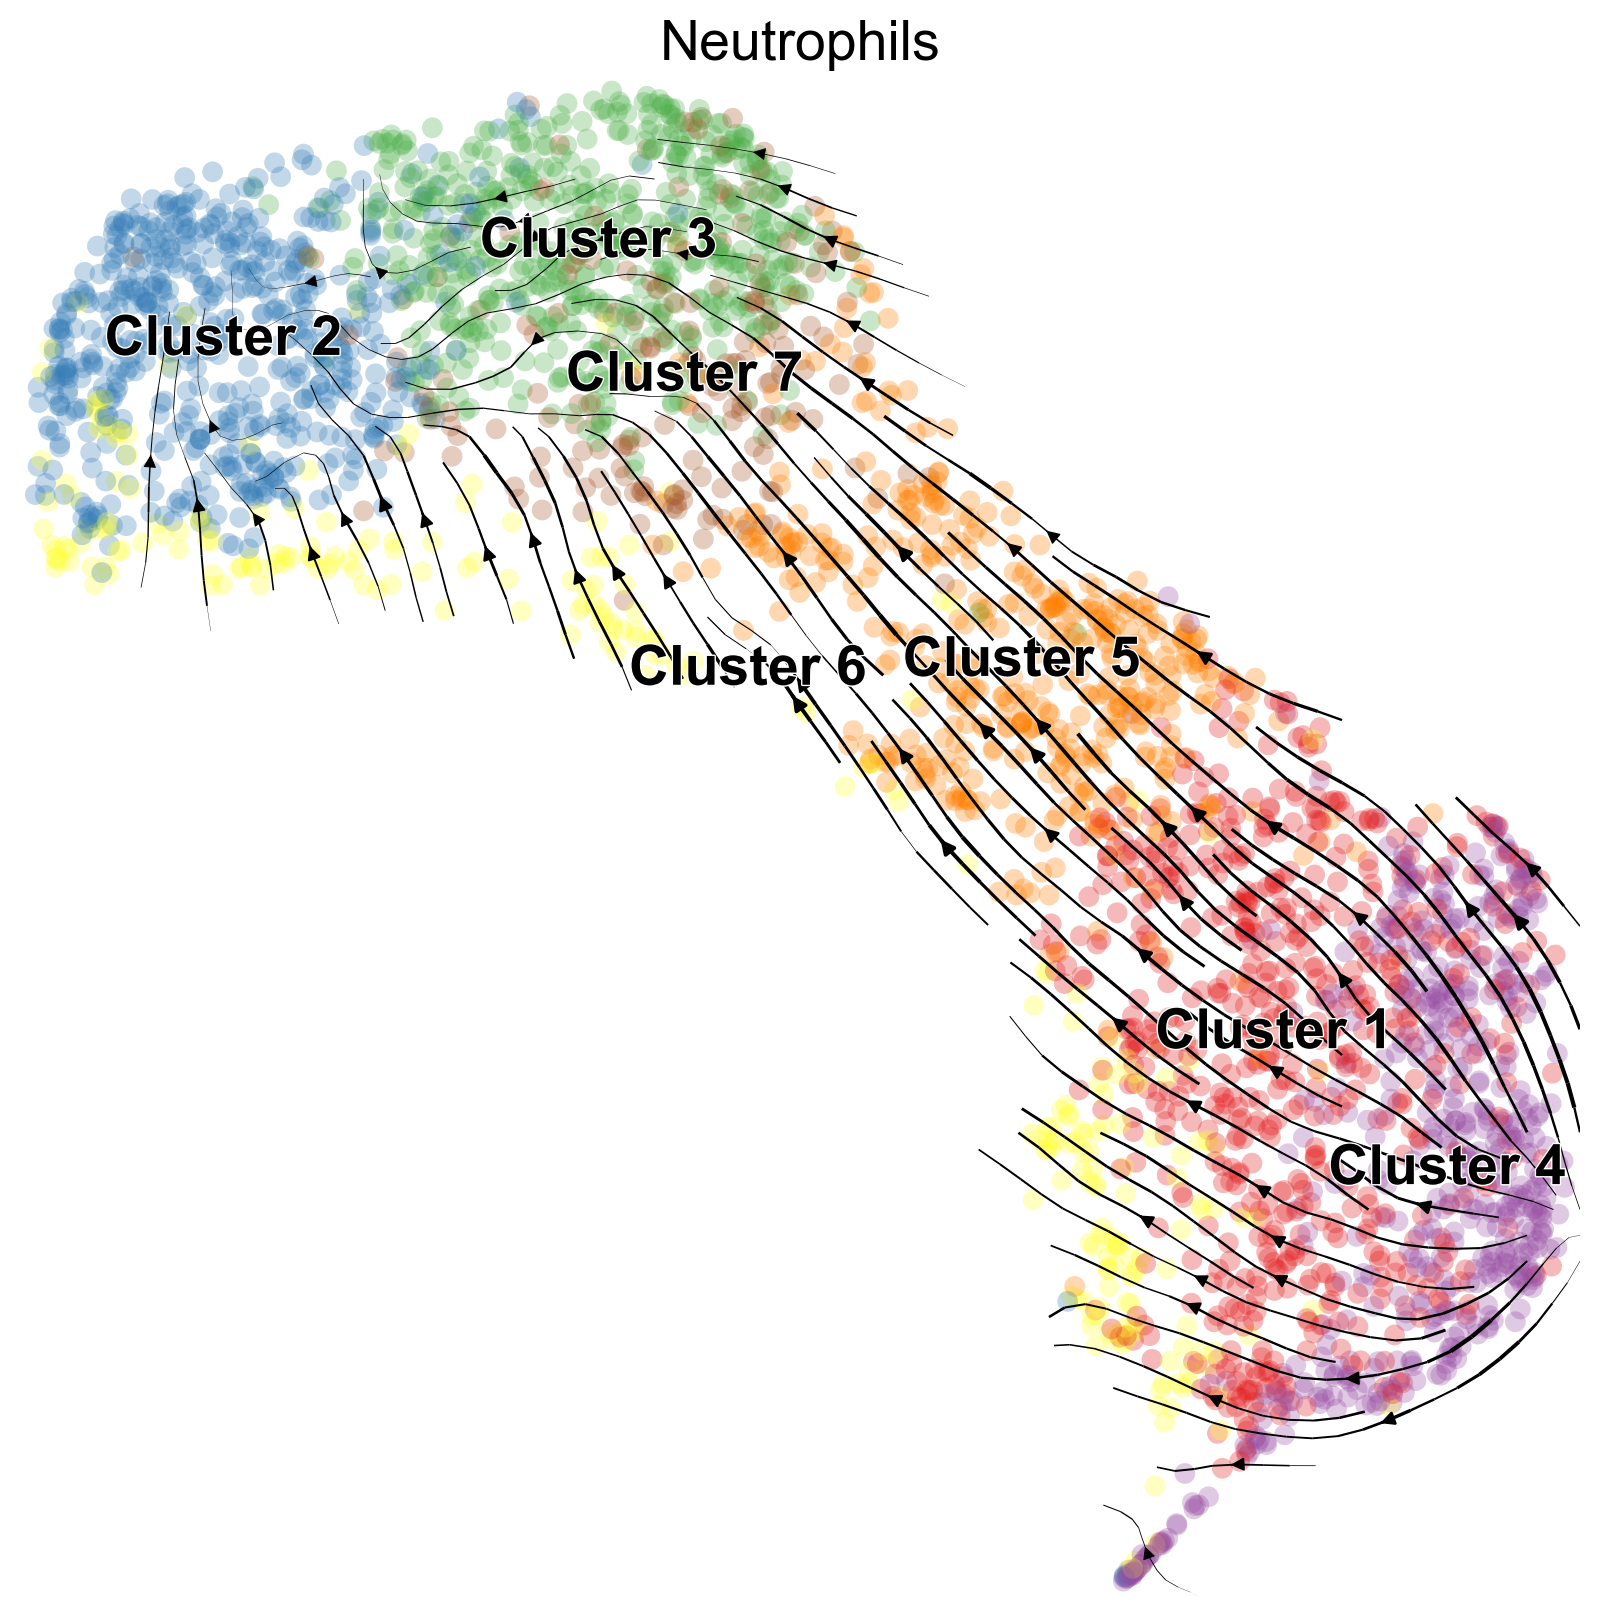

In [18]:
scv.pl.velocity_embedding_stream(Neutro3p,basis="umap",color="Loupe",title='Neutrophils',fontsize=20,legend_fontsize=20,min_mass=2,palette=Colorss,save='scVelo-umap-cluster.png')

saving figure to file ./figures/scvelo_scVelo-umap-latent_time.png


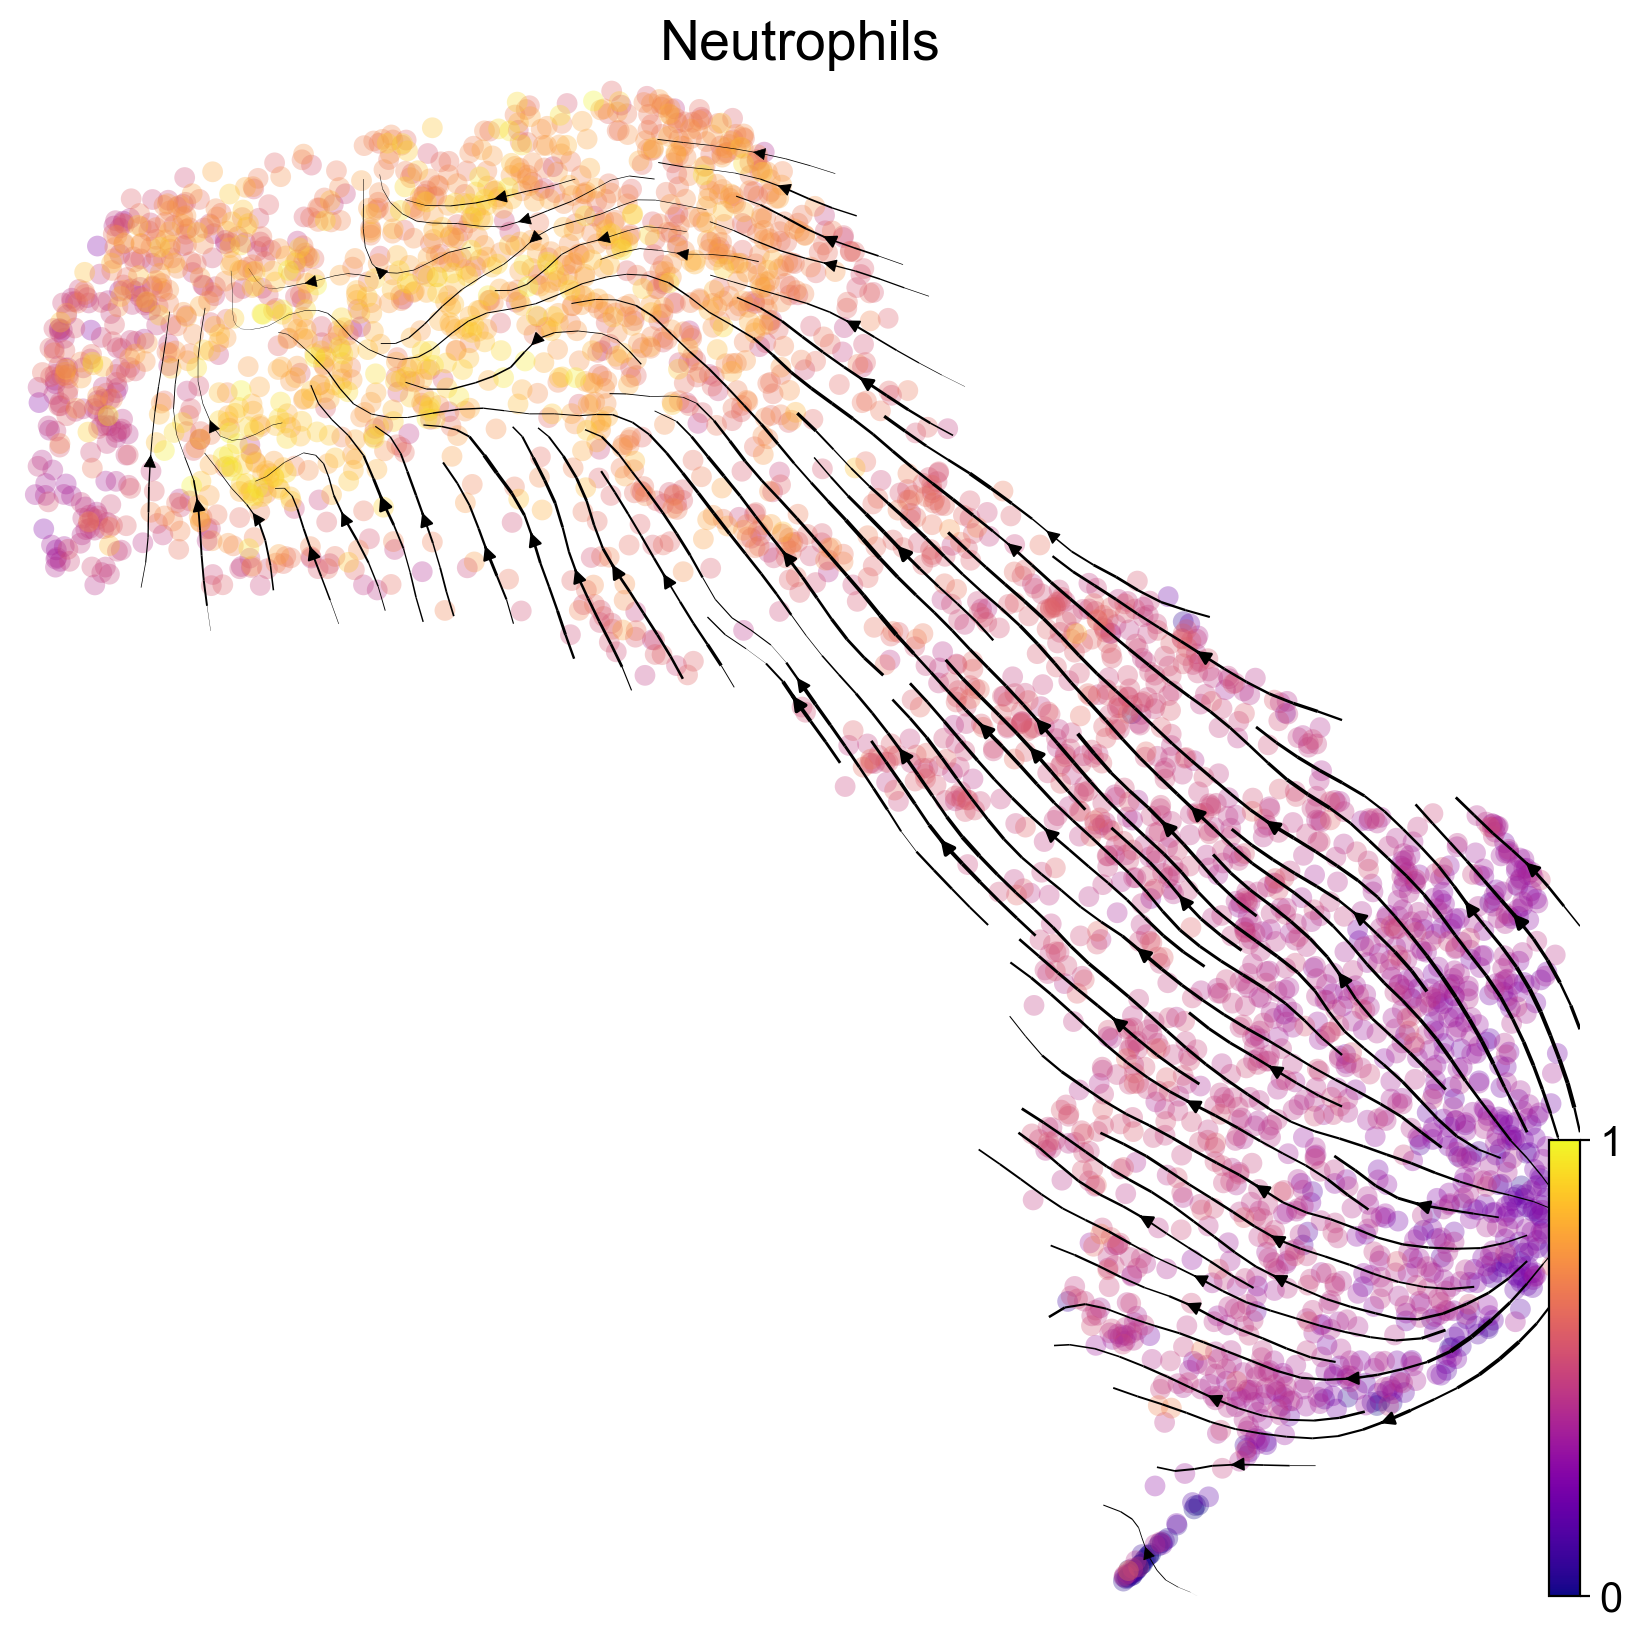

In [19]:
scv.pl.velocity_embedding_stream(Neutro3p,basis="umap",color="latent_time",title='Neutrophils',fontsize=20,legend_fontsize=20,min_mass=2,color_map="plasma",save='scVelo-umap-latent_time.png')

saving figure to file ./figures/scvelo_heatmap_scVelo-heatmap-latent_time.png


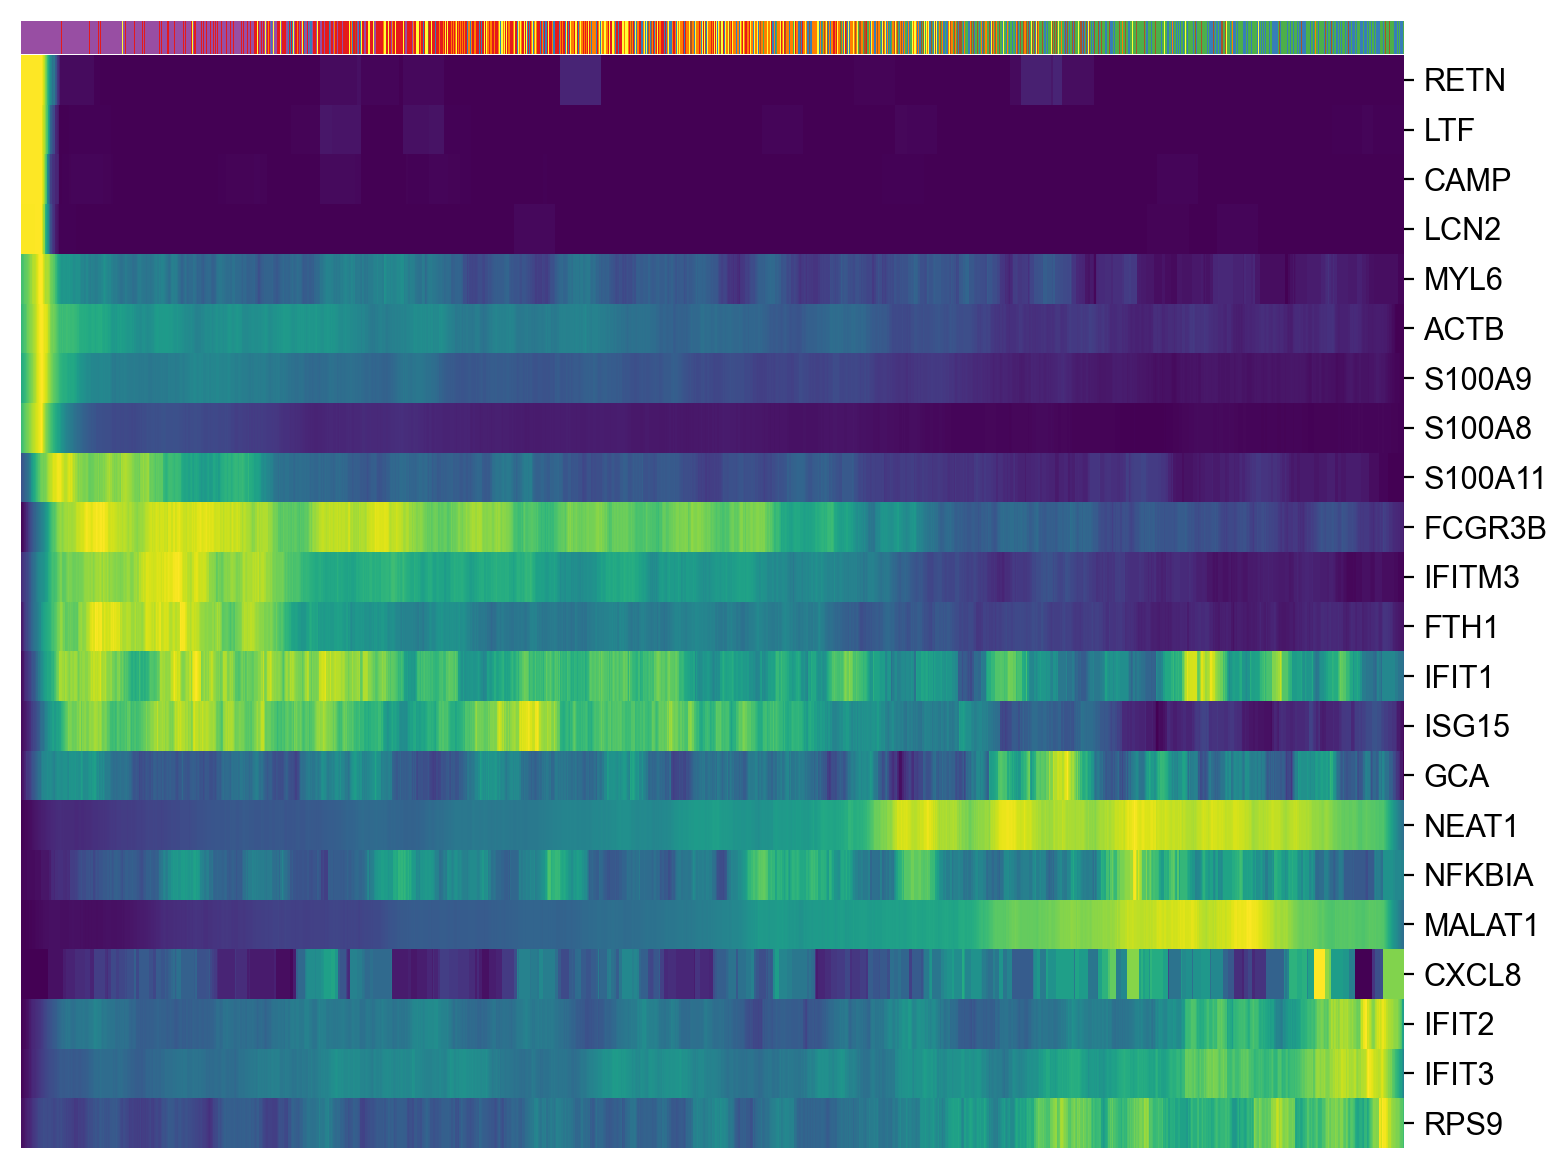

In [20]:
scv.pl.heatmap(Neutro3p, var_names=Genes, sortby='latent_time', col_color='Loupe', n_convolve=100,figsize=(8,6),yticklabels=True,sort=True,colorbar=True,show=True,layer="count", save='scVelo-heatmap-latent_time.png')

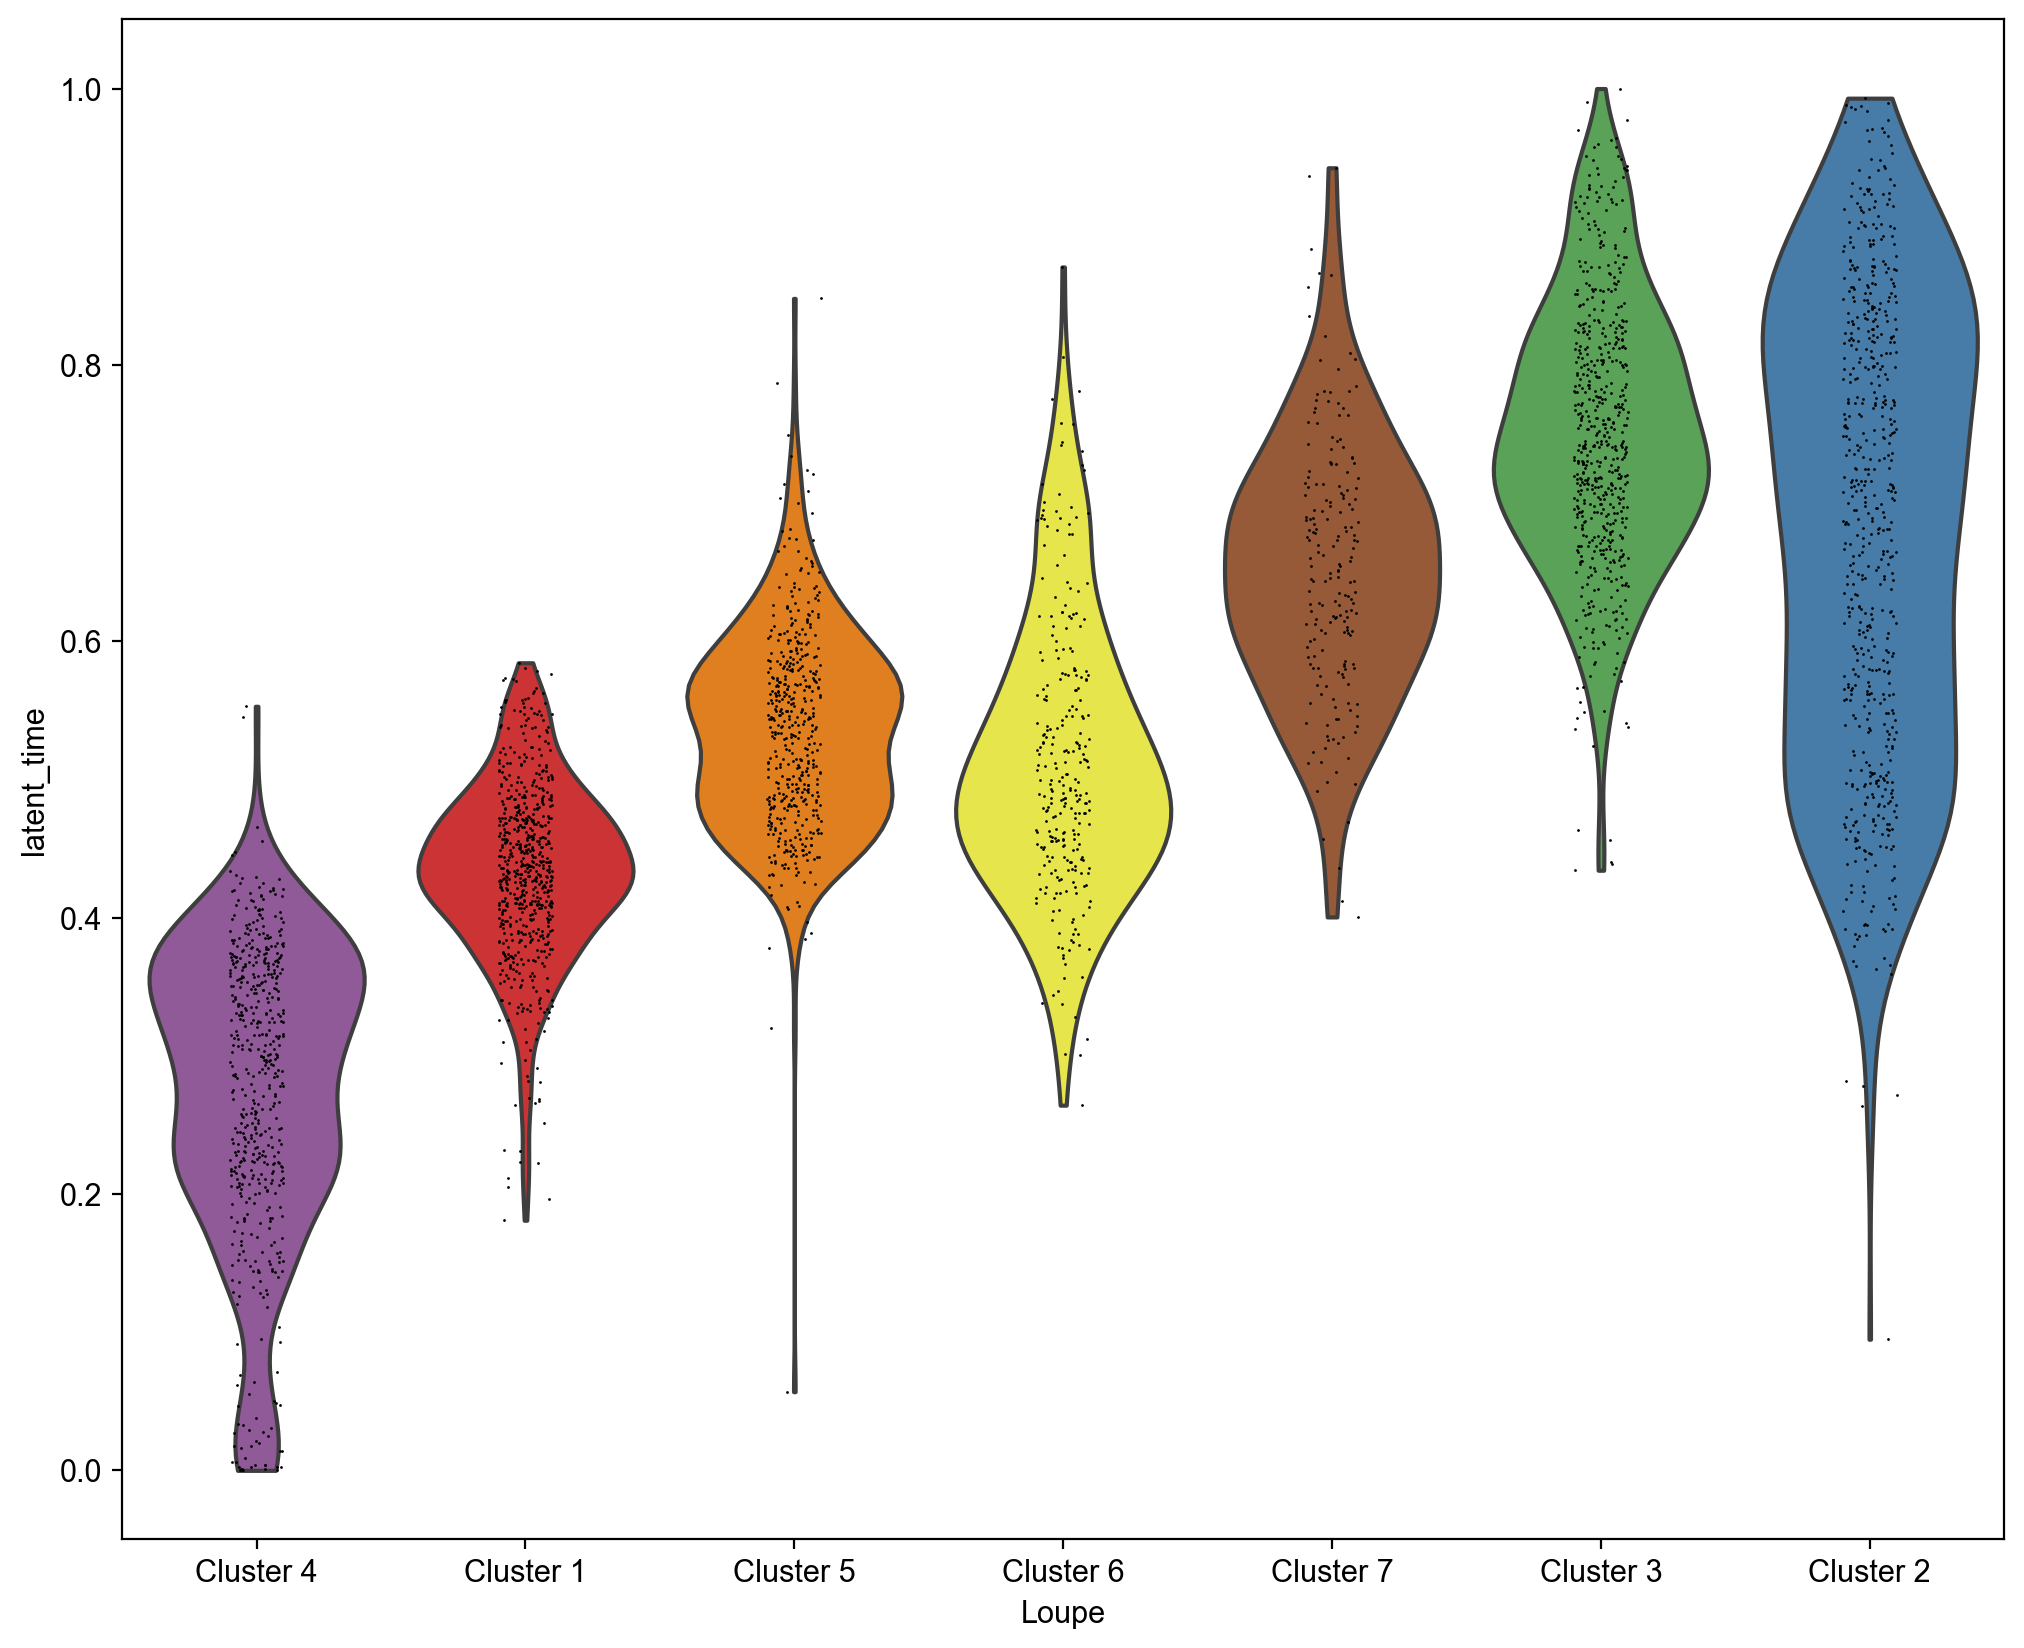

In [21]:
sc.pl.violin(Neutro3p, keys='latent_time',groupby="Loupe",order=["Cluster 4","Cluster 1","Cluster 5","Cluster 6","Cluster 7","Cluster 3","Cluster 2"], save='scVelo-violin-latent_time.png')

For additional information on analysis using this [10x neutrophils dataset](https://www.10xgenomics.com/resources/datasets/whole-blood-rbc-lysis-for-pbmcs-neutrophils-granulocytes-3-3-1-standard), please see this Tech Note, [Neutrophil Analysis in 10x Genomics Single Cell Gene Expression Assays](https://www.10xgenomics.com/support/single-cell-gene-expression/documentation/steps/sample-prep/neutrophil-analysis-in-10-x-genomics-single-cell-gene-expression-assays)